In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
x = torch.tensor(1.0, requires_grad = True, device = device)
y = torch.tensor(2.0, requires_grad = True, device = device)
z = torch.tensor(4.0, requires_grad = True, device = device)

In [4]:
r = ((x*x + y*y)*(z*z))

In [5]:
r.backward()

In [6]:
print('X: {0}, Y: {1}, Z: {2}'.format(x.grad, y.grad, z.grad))

X: 32.0, Y: 64.0, Z: 40.0


In [7]:
# https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/

In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        pred = self.linear(x)
        return pred
    
    def get_model_params(self):
        [w, b] = self.parameters()
        return (w[0][0].item(), b[0].item())

In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [10]:
class ModelPlotter():
    
    def __init__(self, model:LinearModel, data_x, data_y, from_x, to_x):
        self.model = model
        self.X = data_x
        self.y = data_y
        self.from_x = from_x
        self.to_x = to_x

    def plot_fit(self):
        
        # data
        plt.plot(self.X, self.y, 'o')
        
        # model
        w1, b1 = self.model.get_model_params()
        x1 = np.array([self.from_x, self.to_x])
        y1 = w1*x1 + b1
        plt.plot(x1, y1, 'r')
        
        plt.show()

In [11]:
class DataGenerator():
    
    def generate_data(size_data):
        X = np.random.rand(size_data)*10
        Y = X + 2* np.random.rand(size_data)
        return X, Y

    def generate_data_tensor(size_data):
        X = torch.randn(size_data) * 10
        Y = X + 2 * torch.randn(size_data)
        return X, Y

In [12]:
def split_train_test_val(X, y, device, train_ratio, val_ratio):
    
    train_split = int(train_ratio * len(X)) 
    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]
    
    # Create train/valid split
    val_split = int(val_ratio * len(X_train)) 
    idx = list(range(len(X_train)))
    train_idx, val_idx = torch.utils.data.random_split(idx, [train_split - val_split, val_split])
    X_val = X_train[val_idx].clone()
    y_val = y_train[val_idx].clone()
    X_train = X_train[train_idx].clone()
    y_train = y_train[train_idx].clone()
    
    X_train = X_train.reshape(X_train.shape[0], 1).to(device)
    y_train = y_train.reshape(y_train.shape[0], 1).to(device)
    
    X_test = X_test.reshape(X_test.shape[0], 1).to(device)
    y_test = y_test.reshape(y_test.shape[0], 1).to(device)
    
    X_val = X_val.reshape(X_val.shape[0], 1).to(device)
    y_val = y_val.reshape(y_val.shape[0], 1).to(device)

    return X_train, y_train, X_val, y_val, X_test, y_test

Epoch: 0 | MAE Train Loss: 7.328915119171143
Epoch: 1 | MAE Train Loss: 6.713209629058838
Epoch: 2 | MAE Train Loss: 5.493234157562256
Epoch: 3 | MAE Train Loss: 3.7373721599578857
Epoch: 4 | MAE Train Loss: 1.9238580465316772
Epoch: 5 | MAE Train Loss: 2.5500247478485107
Epoch: 6 | MAE Train Loss: 4.500762939453125
Epoch: 7 | MAE Train Loss: 6.100043773651123
Epoch: 8 | MAE Train Loss: 7.139211177825928
Epoch: 9 | MAE Train Loss: 7.575856685638428
Epoch: 10 | MAE Train Loss: 7.399232864379883
Epoch: 11 | MAE Train Loss: 6.612688064575195
Epoch: 12 | MAE Train Loss: 5.240571975708008
Epoch: 13 | MAE Train Loss: 3.3862228393554688
Epoch: 14 | MAE Train Loss: 1.7384544610977173
Epoch: 15 | MAE Train Loss: 2.913416624069214
Epoch: 16 | MAE Train Loss: 4.88928747177124
Epoch: 17 | MAE Train Loss: 6.413463115692139
Epoch: 18 | MAE Train Loss: 7.346829891204834
Epoch: 19 | MAE Train Loss: 7.664814472198486
Epoch: 20 | MAE Train Loss: 7.36461877822876
Epoch: 21 | MAE Train Loss: 6.44833660125

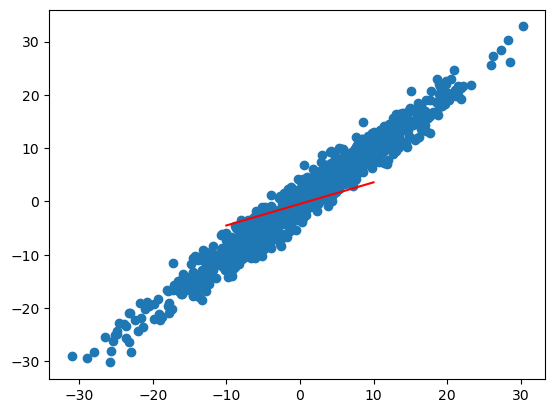

In [13]:
set_seed(42)

data_size = 1000
epochs = 100
use_validation_set = False

# Create empty loss lists to track values
train_loss_values = []
val_loss_values = []
epoch_count = []

# generate and split data
data = DataGenerator.generate_data_tensor(data_size)
X_train, y_train, X_test, y_test, X_val, y_val = split_train_test_val(data[0], data[1], device, 1, 0.01)

model = LinearModel(1,1)
model.to(device)
plotter = ModelPlotter(model, data[0].numpy(), data[1].numpy(), -10, 10)

learning_rate = 0.01
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    
    # set train mode
    model.train()
    
    # make prediction
    y_pred = model(X_train)
    
    # calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # back propogate
    loss_fn.zero_grad()
    loss.backward()
    optimizer.step()
    
    # set model to eval mode
    model.eval()
    
    if use_validation_set == False: print(f"Epoch: {epoch} | MAE Train Loss: {loss}")
    
    if use_validation_set == True:
        with torch.inference_mode():
            # calculate loss on validation set
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val.type(torch.float)) 
            # print losses
            if epoch % 5 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.cpu().detach().numpy())
                val_loss_values.append(val_loss.cpu().detach().numpy())
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Val Loss: {val_loss}")
                  
plotter.plot_fit()

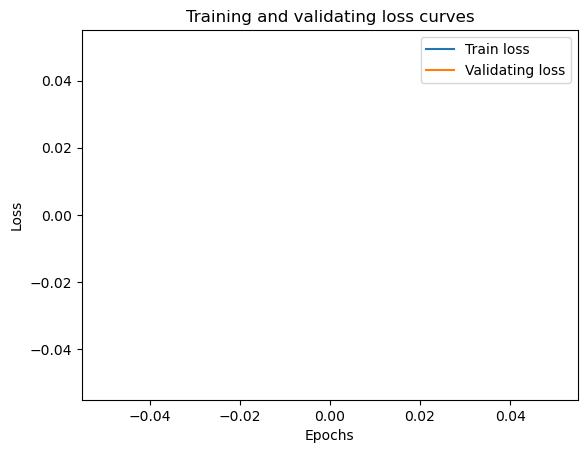

In [14]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, val_loss_values, label="Validating loss")
plt.title("Training and validating loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();